In [4]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

dataroot = '../WaterLevelPrediction_SelectingModel//Data/'

In [5]:
df = pd.read_pickle(dataroot+'finaldata.pkl')

Cross Validation

In [6]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=6, test_size=365)
df = df.sort_index()

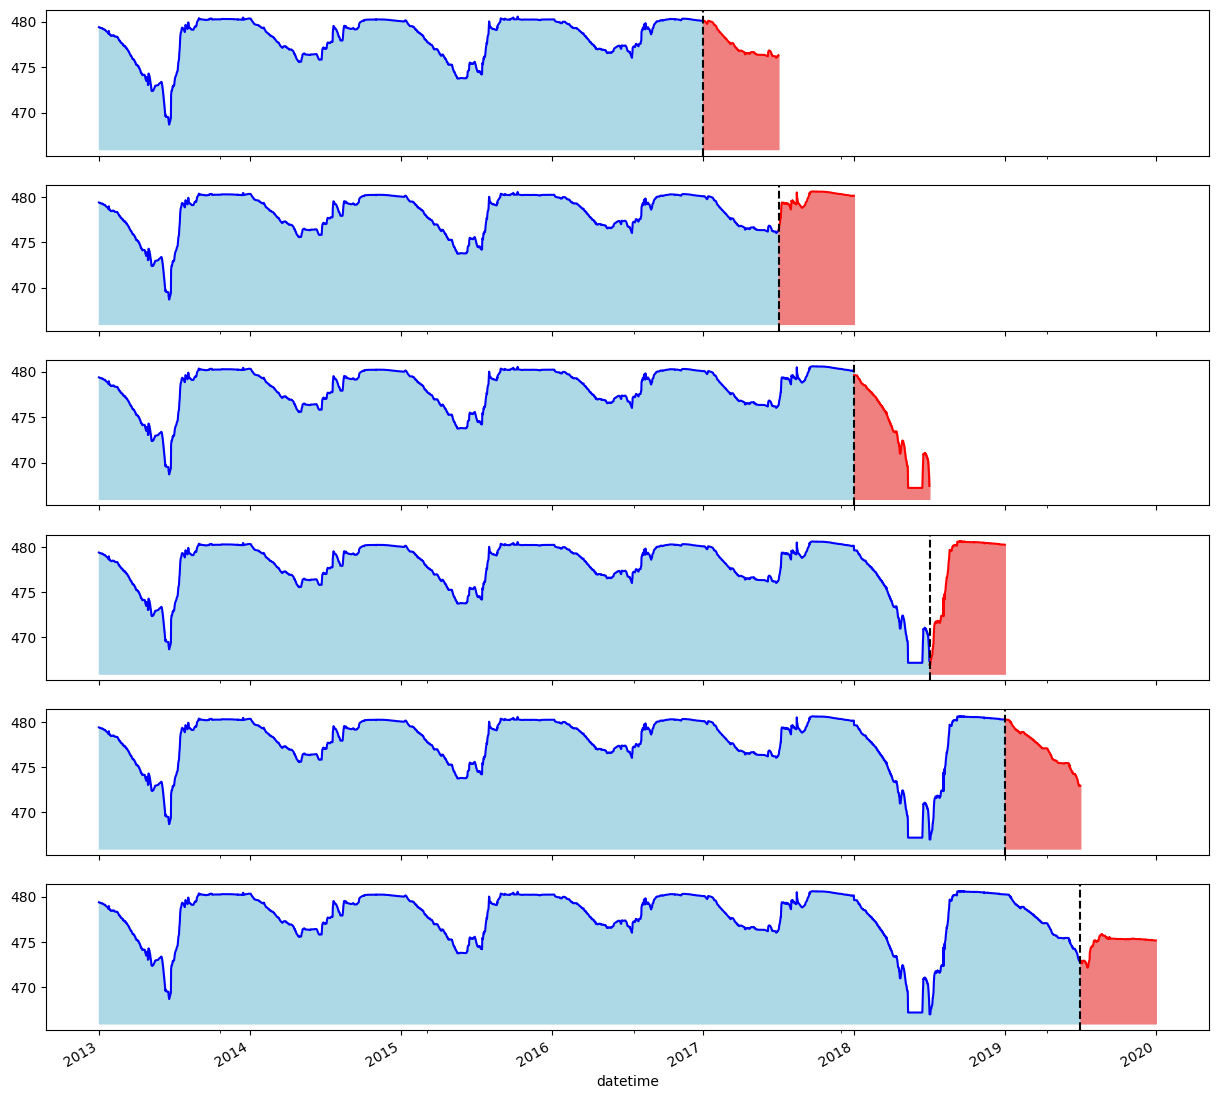

In [7]:
fig, axs = plt.subplots(6,1, figsize = (15,15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['water_level'].plot(ax=axs[fold],
                              label='Tập huấn luyện',
                              color='blue')
    test['water_level'].plot(ax=axs[fold],
                             label='Tập kiểm thử',
                             color='red')
    axs[fold].fill_between(train.index,466, train['water_level'], color='lightblue')
    axs[fold].fill_between(test.index,466, test['water_level'], color='lightcoral')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold+=1
plt.show()

Train the model with first features set

In [10]:
from sklearn.ensemble import RandomForestRegressor

fold = 0
preds = []
rmses = []
maes = []
r2s = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    
    features = ['precipitation','sluice_status']
    target = 'water_level'
    
    X_train = train[features]
    y_train = train[target]
    
    X_test = test[features]
    y_test = test[target]
    
    rf_reg = RandomForestRegressor()
    rf_reg.fit(X_train, y_train)
    
    y_pred = rf_reg.predict(X_test)
    preds.append(y_pred)
    rmse = np.sqrt(mean_squared_error(y_test,y_pred))
    rmses.append(rmse)
    mae = mean_absolute_error(y_test,y_pred)
    maes.append(mae)
    r2 = r2_score(y_test,y_pred)
    r2s.append(r2)

Model and Fold score

In [ ]:
print(f'mean squared error across fold:{np.mean(rmses)}')
print(f'score for each fold:{rmses}')
print(f'mean absolute error across fold:{np.mean(maes)}')
print(f'score for each fold:{maes}')
print(f'r2 score across fold:{np.mean(r2s)}')
print(f'score for each fold:{r2s}')

Plot for Model Performance

In [ ]:
fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    plt.figure(figsize=(10, 6))
    plt.plot(test.index, test['water_level'], label='Thực đo', color='blue')
    plt.plot(test.index, preds[fold], label='Dự đoán', color='red', linestyle='dashed')
    fold += 1

    plt.title('Fold {} - Thực đo vs. Dự đoán'.format(fold))

    plt.legend()
    plt.grid()
    plt.show()

Create Lag Feature

In [8]:
def add_lag(df):
    target_map = df['water_level'].to_dict() # mapping water level
    df['lag'] = (df.index - pd.Timedelta('12 hours')).map(target_map)# lag 12 hours
    return df

df = add_lag(df)
df = df.dropna(subset=['lag'])# drop the NaN value because model won't accept it
df.head()

,year,month,day,water_level,hour,precipitation,sluice_status,datetime,lag
datetime,,,,,,,,,
2013-01-01 19:00:00,2013,1,1,479.38,19,0.0,0,2013-01-01 19:00:00,479.40
2013-01-02 07:00:00,2013,1,2,479.37,7,0.0,5,2013-01-02 07:00:00,479.38
2013-01-02 19:00:00,2013,1,2,479.36,19,0.0,5,2013-01-02 19:00:00,479.37
2013-01-03 07:00:00,2013,1,3,479.36,7,0.0,5,2013-01-03 07:00:00,479.36
2013-01-03 19:00:00,2013,1,3,479.36,19,0.0,5,2013-01-03 19:00:00,479.36


Retrain the model with second feature set

In [11]:
fold = 0
preds = []
rmses = []
maes = []
r2s = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    
    features = ['precipitation','sluice_status','lag']
    target = 'water_level'
    
    X_train = train[features]
    y_train = train[target]
    
    X_test = test[features]
    y_test = test[target]
    
    rf_reg = RandomForestRegressor()
    rf_reg.fit(X_train, y_train)
    
    y_pred = rf_reg.predict(X_test)
    preds.append(y_pred)
    rmse = np.sqrt(mean_squared_error(y_test,y_pred))
    rmses.append(rmse)
    mae = mean_absolute_error(y_test,y_pred)
    maes.append(mae)
    r2 = r2_score(y_test,y_pred)
    r2s.append(r2)

In [ ]:
print(f'mean squared error across fold:{np.mean(rmses)}')
print(f'score for each fold:{rmses}')
print(f'mean absolute error across fold:{np.mean(maes)}')
print(f'score for each fold:{maes}')
print(f'r2 score across fold:{np.mean(r2s)}')
print(f'score for each fold:{r2s}')

Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap' : [True, False],
    'max_features': [None, 'sqrt', 'log2'],
}

rf_reg = RandomForestRegressor()

grid_search = GridSearchCV(estimator=rf_reg, param_grid=param_grid, cv=tss)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

In [12]:

fold = 0
preds = []
rmses = []
maes = []
r2s = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    
    features = ['precipitation','sluice_status','lag']
    target = 'water_level'
    
    X_train = train[features]
    y_train = train[target]
    
    X_test = test[features]
    y_test = test[target]
    
    rf_reg = RandomForestRegressor(n_estimators=best_params['n_estimators'],
                                   max_depth=best_params['max_depth'],
                                   max_features=best_params['max_features'],
                                   min_samples_leaf=best_params['min_samples_leaf'],
                                   min_samples_split=best_params['min_samples_split'],
                                   bootstrap=best_params['bootstrap'],
                                    n_jobs=-1
                                   )
    rf_reg.fit(X_train, y_train)
    
    y_pred = rf_reg.predict(X_test)
    preds.append(y_pred)
    rmse = np.sqrt(mean_squared_error(y_test,y_pred))
    rmses.append(rmse)
    mae = mean_absolute_error(y_test,y_pred)
    maes.append(mae)
    r2 = r2_score(y_test,y_pred)
    r2s.append(r2)

NameError: name 'best_params' is not defined

In [ ]:
print(f'mean squared error across fold:{np.mean(rmses)}')
print(f'score for each fold:{rmses}')
print(f'mean absolute error across fold:{np.mean(maes)}')
print(f'score for each fold:{maes}')
print(f'r2 score across fold:{np.mean(r2s)}')
print(f'score for each fold:{r2s}')

In [ ]:
fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    plt.figure(figsize=(10, 6))
    plt.plot(test.index, test['water_level'], label='Thực đo', color='blue')
    plt.plot(test.index, preds[fold], label='Dự đoán', color='red', linestyle='dashed')
    fold += 1

    plt.title('Fold {} - Thực đo vs. Dự đoán'.format(fold))

    plt.legend()
    plt.grid()
    plt.show()

In [18]:
# Prepare the input data for prediction

input_data = [[27,0,471.8],[49,0,472.35],[26,0,473.15]]

# Create a dataframe from the input data
input_df = pd.DataFrame(input_data)

# Make predictions
predictions = rf_reg.predict(input_df)

# Print the predictions
print(predictions)

[471.94269167 472.6667     473.2193    ]


C:\Users\ADMIN\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
